### Libs

In [24]:
import requests
import json
import numpy as np
import pandas as pd
from IPython.display import clear_output

### Data

In [25]:
with open('dataset\cvrp_castanhal_completo.json') as json_file:
    raw_data = json.load(json_file)

In [26]:
raw_data.keys()

dict_keys(['name', 'region', 'origin', 'vehicle_capacity', 'deliveries'])

In [27]:
raw_data["origin"]

{'lng': -47.93317089927402, 'lat': -1.2923387357484621}

In [28]:
raw_data["vehicle_capacity"]

180

In [29]:
raw_data["deliveries"][0]

{'id': '245aed8b07925496f14cc83f85a95318',
 'point': {'lng': -48.083796008609376, 'lat': -1.3859328704379723},
 'size': 8}

### General Class

In [30]:
class Coordinate:
    def __init__(self, lat, lng):
        self.lat = lat
        self.lng = lng

In [31]:
class Delivery:
    def __init__(self, raw_delivery, index):
        self.id = index+1
        self.point = Coordinate(str(raw_delivery["point"]["lat"]), str(raw_delivery["point"]["lng"]))
        self.size = raw_delivery["size"]

In [32]:
class DepotNet:
    def __init__(self, raw_data):
        self.name = raw_data["name"]
        self.region = raw_data["region"]
        self.origin = Coordinate(str(raw_data["origin"]["lat"]), str(raw_data["origin"]["lng"]))
        self.vehicle_capacity = raw_data["vehicle_capacity"]
        self.deliveries = [Delivery(raw_data["deliveries"][i], i) for i in range(len(raw_data["deliveries"]))]

### Tabu Search

In [33]:
#Class Tabu Search for the problem of the CVRP
class TabuSearch:
    def __init__(self, depot_net, max_iterations, n_neighbors, tabu_list_size):
        self.depot_net = depot_net
        self.max_iterations = max_iterations
        self.n_neighbors = n_neighbors
        self.tabu_list_size = tabu_list_size
        self.solution = []
        self.best_solution = []
        self.best_solutions = pd.DataFrame(columns=[f"x_{i}" for i in range(len(self.depot_net.deliveries))]+["y"])
        self.best_neighborhood = pd.DataFrame(columns=[f"x_{i}" for i in range(len(self.depot_net.deliveries))]+["y"])
        self.tabu_list = []
        self.run()

    def generate_solution_initial(self):
        n = len(self.depot_net.deliveries)
        solution = np.random.choice([i for i in range(n)], n, replace=False)
        return [self.depot_net.deliveries[idx].id for idx in solution]
    
    def udpate_best_solutions(self, solution, solution_cost):
        s = pd.Series([self.depot_net.deliveries[idx-1].id for idx in solution]+[solution_cost],index=[f"x_{i}" for i in range(len(solution))]+["y"])
        self.best_solutions = self.best_solutions.append(s, ignore_index=True)
        df = self.best_solutions.iloc[:, :-1].astype(int)
        df["y"] = self.best_solutions["y"]
        self.best_solutions = df

    def udpate_best_neighborhood(self, solution, solution_cost):
        s = pd.Series([self.depot_net.deliveries[idx-1].id for idx in solution]+[solution_cost],index=[f"x_{i}" for i in range(len(solution))]+["y"])
        self.best_neighborhood = self.best_neighborhood.append(s, ignore_index=True)
        df = self.best_neighborhood.iloc[:, :-1].astype(int)
        df["y"] = self.best_neighborhood["y"]
        self.best_neighborhood = df
    
    def solution_cost(self, solution, save=False):
        solution_cost = 0
        route_list = [f"{self.depot_net.origin.lng},{self.depot_net.origin.lat}"]
        weight = 0
        for delivery in [self.depot_net.deliveries[idx-1] for idx in solution]:
            weight += delivery.size
            if weight <= self.depot_net.vehicle_capacity:
                route_list.append(f"{delivery.point.lng},{delivery.point.lat}")
            else:
                route_list.append(f"{self.depot_net.origin.lng},{self.depot_net.origin.lat}")
                route_list.append(f"{delivery.point.lng},{delivery.point.lat}")
                weight = 0
        route_list.append(f"{self.depot_net.origin.lng},{self.depot_net.origin.lat}")
        route_str = ";".join(route_list)
        query = f"https://router.project-osrm.org/route/v1/driving/{route_str}?overview=false"
        #print(query)
        response = requests.get(query)
        data = response.json()
        #salvar resposta da requisição em arquivo no formato json
        if save:
            with open('best_routes_cvrp.json', 'w') as outfile:
                json.dump(data, outfile)
        solution_cost = data["routes"][0]["distance"]
        return solution_cost
    
    def swap(self, solution):
        i, j = np.random.choice(len(solution)-1, 2, replace=False)
        solution[i], solution[j] = solution[j], solution[i]
        return solution
    
    def diference_solutions(self, solution, best_neighbor):
        indexs = [i for i in range(len(solution)) if solution[i] != best_neighbor[i]]
        return indexs
    
    def generate_neighbors(self, iteration):
        neighbors = []
        neighbors_cost = []
        for _ in range(self.n_neighbors):
            neighbor = self.swap(self.solution.copy())
            while neighbor in neighbors:
                neighbor = self.swap(self.solution.copy())
            neighbor_cost = self.solution_cost(neighbor)
            if neighbors_cost == []:
                neighbors.append(neighbor)
                neighbors_cost.append(neighbor_cost)
            else:
                for k in range(len(neighbors_cost)):
                    if neighbor_cost < neighbors_cost[k]:
                        neighbors.insert(k, neighbor)
                        neighbors_cost.insert(k, neighbor_cost)
                        break
                    if k == len(neighbors_cost)-1:
                        neighbors.append(neighbor)
                        neighbors_cost.append(neighbor_cost)
        self.update_tabu_list(neighbors, neighbors_cost, iteration)
    
    def update_tabu_list(self, neighbors, neighbors_cost, iteration):
        if neighbors_cost[0] < self.solution_cost(self.best_solution):
            if len(self.tabu_list) == self.tabu_list_size:
                self.tabu_list.pop(0)
            self.tabu_list.append(self.diference_solutions(self.solution, neighbors[0]))
            self.solution = neighbors[0]
            #print(f'Mudou para melhor na iteração {iteration}')
            self.best_solution = neighbors[0]
            self.udpate_best_neighborhood(neighbors[0], neighbors_cost[0])
        else:
            for l in range(self.n_neighbors):
                indexs_swap = self.diference_solutions(self.solution, neighbors[l])
                if indexs_swap in self.tabu_list:
                    continue
                else:
                    if len(self.tabu_list) == self.tabu_list_size:
                        self.tabu_list.pop(0)
                    self.tabu_list.append(indexs_swap)
                    self.solution = neighbors[l]
                    #print(f'Mudou para pior na iteração {iteration}')
                    self.udpate_best_neighborhood(neighbors[l], neighbors_cost[l])
                    break
                
    def progress_bar(self, i):
        clear_output(wait=True)
        pc = int(i/self.max_iterations*100)
        logic_char = 0 if i == 1 else int(pc/2)
        print(f"Executando iteração {i}/{self.max_iterations}:|{'█' * logic_char + '.' * (50 - logic_char)}|{pc}%",
              end='\r', flush=True)

    def run(self):
        self.solution = self.generate_solution_initial()
        self.best_solution = self.solution
        initial = [self.solution, self.solution_cost(self.solution)]
        for i in range(self.max_iterations):
            self.progress_bar(i+1)
            self.generate_neighbors(i)
            self.udpate_best_solutions(self.best_solution, self.solution_cost(self.best_solution))
        #limpar a tela
        clear_output(wait=True)
        print(f'Solução inicial:\n{initial[0]}\nCusto: {initial[1]}')
        print(f'Após {i+1} iterações, temos:')
        print(f'Solução Final:\n{self.best_solution}\nCusto: {self.solution_cost(self.best_solution)}')

### Run

In [34]:
depot_net = DepotNet(raw_data)
max_iterations = 500
n_neighbors = 10
tabu_list_size = 5

#Criar instância do algoritmo (com execução automática)
tabu = TabuSearch(depot_net, max_iterations, n_neighbors, tabu_list_size)

Solução inicial:
[2, 5, 15, 25, 22, 28, 3, 24, 8, 26, 21, 33, 13, 10, 12, 7, 1, 30, 35, 6, 23, 16, 34, 4, 19, 18, 9, 14, 32, 29, 11, 20, 17, 27, 31]
Custo: 447662.6
Após 500 iterações, temos:
Solução Final:
[2, 6, 1, 3, 5, 4, 27, 15, 24, 25, 17, 12, 26, 28, 22, 8, 20, 14, 21, 10, 9, 35, 34, 32, 18, 33, 11, 19, 13, 23, 16, 7, 30, 29, 31]
Custo: 147098.7


### Analysis

##### Save response request OSRM

In [35]:
tabu.solution_cost(tabu.best_solution, save=True)

with open('best_routes_cvrp.json', 'r') as outfile:
    data = json.load(outfile)     

##### Best neighborhood

In [36]:
print(f'Melhores soluções das vizinhanças:')
display(tabu.best_neighborhood)
best_cost_neighborhood = tabu.best_neighborhood["y"].min()
index_best_neighborhood = tabu.best_neighborhood.loc[tabu.best_neighborhood["y"] == best_cost_neighborhood].index
print(f'Melhor(res) solução(ões) apresentada(s) no(s) índece(s):\n{index_best_neighborhood.astype(int).tolist()}')

Melhores soluções das vizinhanças:


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,y
0,2,5,15,25,22,28,3,24,8,26,...,9,14,32,29,11,20,17,27,31,378501.6
1,2,5,15,25,22,9,3,24,8,26,...,28,14,32,29,11,20,17,27,31,375657.8
2,2,5,15,25,22,9,3,24,8,26,...,28,14,32,29,11,20,17,34,31,370558.8
3,2,5,17,25,22,9,3,24,8,26,...,28,14,32,29,11,20,15,34,31,368703.2
4,2,5,17,25,22,9,3,24,8,26,...,28,14,32,29,7,20,15,34,31,366892.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3,1,2,6,5,4,23,18,28,20,...,25,13,22,21,9,7,16,34,31,152219.8
496,3,1,2,6,5,4,23,18,12,20,...,25,13,22,21,9,7,16,34,31,152095.9
497,3,1,2,6,5,4,23,18,12,20,...,25,13,22,21,9,7,16,34,31,152179.9
498,3,1,2,6,5,4,23,18,12,20,...,25,13,22,21,9,7,16,34,31,152179.9


Melhor(res) solução(ões) apresentada(s) no(s) índece(s):
[369]


##### Best solutions

In [37]:
print(f'Melhores soluções globais por iteração:')
display(tabu.best_solutions)
index_best_solutions = tabu.best_solutions.loc[tabu.best_solutions["y"] == tabu.best_solutions["y"].min()].index
print(f'Melhor(res) solução(ões) apresentada(s) no(s) índece(s):\n{index_best_solutions.astype(int).tolist()}')

Melhores soluções globais por iteração:


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,y
0,2,5,15,25,22,28,3,24,8,26,...,9,14,32,29,11,20,17,27,31,378501.6
1,2,5,15,25,22,9,3,24,8,26,...,28,14,32,29,11,20,17,27,31,375657.8
2,2,5,15,25,22,9,3,24,8,26,...,28,14,32,29,11,20,17,34,31,370558.8
3,2,5,17,25,22,9,3,24,8,26,...,28,14,32,29,11,20,15,34,31,368703.2
4,2,5,17,25,22,9,3,24,8,26,...,28,14,32,29,7,20,15,34,31,366892.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2,6,1,3,5,4,27,15,24,25,...,11,19,13,23,16,7,30,29,31,147098.7
496,2,6,1,3,5,4,27,15,24,25,...,11,19,13,23,16,7,30,29,31,147098.7
497,2,6,1,3,5,4,27,15,24,25,...,11,19,13,23,16,7,30,29,31,147098.7
498,2,6,1,3,5,4,27,15,24,25,...,11,19,13,23,16,7,30,29,31,147098.7


Melhor(res) solução(ões) apresentada(s) no(s) índece(s):
[369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]


##### Graphic minimization

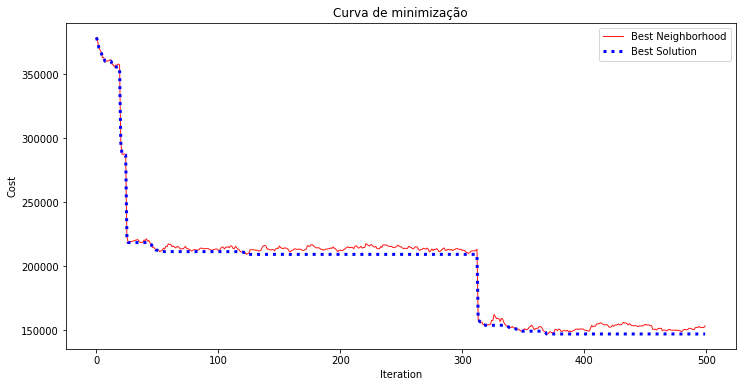

In [44]:
import matplotlib.pyplot as plt

x = np.arange(0, tabu.max_iterations, 1)
y1 = tabu.best_neighborhood["y"]
y2 = tabu.best_solutions["y"]
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
lines = ax.plot(x, y1, color='red', lw=1, alpha=0.9)
ax.plot(x, y2, color='blue', lw=3, linestyle=':')
ax.set_title('Curva de minimização')
ax.set_xlabel('Iteration')
ax.set_ylabel('Cost')
ax.legend(['Best Neighborhood', 'Best Solution'])
plt.show()